In [1]:
#@title Import Modules
import math
import functools
import random

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from collections import Counter
from sklearn.decomposition import PCA
from torch.utils.data import TensorDataset
from torchvision import datasets, transforms

In [2]:
#@title Define Hyperparameters
if(torch.backends.mps.is_available()):
    device = 'mps'
elif (torch.cuda.is_available()):
    device = 'cuda'
else:
    device = 'cpu'

# Experiment parameters
tasks           = [(0,2), (5,6), (3,8)]
numOutput       = 0
for task in tasks:
    numOutput += len(task)
num_PCA         = 64
storage_size    = 4096
dataset         = datasets.MNIST
transform       = transforms.ToTensor()
train_batch_size = 512
test_batch_size = 512

# Offline Parameters
epochs          = 10
offline_lr      = 7e-2
milestones      = [epochs//2]
gamma           = 0.5
batch_size      = storage_size // 8
momentum        = 0
weight_decay    = 0

# Online Parameters
online_lr       = 7e-4

# Mutual Information Parameters
n_bins          = 10

In [3]:
pca_components = 12

#@title Data Retrieval
def process_data(data, task):
    conditions = []
    for c in task:
      conditions.append((data.targets == c))
    indices = functools.reduce(torch.logical_or, conditions)
    data.data, data.targets = data.data[indices], data.targets[indices]
    for i in range(len(task)):
      data.targets[data.targets == task[i]] = i
    data = TensorDataset(data.data.reshape(-1, 28*28), data.targets)
    return data

def get_loaders(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

    # Make dataset loaders
    online_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True, drop_last=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return online_loader, test_loader

def get_pretrain_loaders(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])

    # Make dataset loaders
    online_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=train_batch_size, shuffle=True, drop_last=True
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return online_loader, test_loader

def get_test_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)
    test_dataset  = process_data(dataset('../data', download=True, train=False, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])
    test_dataset.tensors  = (torch.from_numpy(pca.transform(test_dataset.tensors[0])).float(), test_dataset.tensors[1])
    test_loader   = torch.utils.data.DataLoader(
        test_dataset, batch_size=test_batch_size, shuffle=False, drop_last=False
    )
    return test_loader

def get_MI_loader(task):
    train_dataset = process_data(dataset('../data', download=True, train=True, transform=transform), task)

    # use PCA to reduce to lower dimensions
    pca = PCA(n_components=pca_components)
    pca.fit(train_dataset.tensors[0])
    train_dataset.tensors = (torch.from_numpy(pca.transform(train_dataset.tensors[0])).float(), train_dataset.tensors[1])

    # Make dataset loaders
    MI_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=len(train_dataset), shuffle=False, drop_last=False
    )
    return MI_loader

In [4]:
def test_tasks(model, class_heads, tasks):
    # test tasks individually
    model.eval()
    test_set_accuracy = {}
    for taskNum in range(len(tasks)):
        print("        Testing task:", taskNum+1, "/", len(tasks), end=": ")
        test_loader = get_test_loader(tasks[taskNum])
        N = 0
        accuracy = 0
        for batch_idx, (images, labels) in enumerate(test_loader, start=1):
            images, labels = images.to(device), labels.to(device)

            # forward pass
            h1, h2, h3, h4, h5 = model(images)
            h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

            # check if predicted labels are equal to true labels
            predicted_labels = torch.argmax(h6,dim=1)
            accuracy += torch.sum((predicted_labels==labels).float()).item()
            N += images.shape[0]
        print(str(round(100. * accuracy/N)) + "%")
        test_set_accuracy[taskNum] = 100. * accuracy/N

    print("        Testing global accuracy: ", end="")

    N = 0
    accuracy = 0
    for taskNum, task in enumerate(tasks):
      test_loader = get_test_loader([c for c in task])
      for batch_idx, (images, labels) in enumerate(test_loader, start=1):
        images, labels = images.to(device), labels.to(device)

        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]

    print(str(round(100. * accuracy/N)) + "%")
    total_accuracy = 100. * accuracy/N
    return total_accuracy, test_set_accuracy

In [5]:
#@title Mutual Information Computer
def compute_mutual_information(model, class_heads, taskNum, data_loader):
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)

    h_list = model(images)
    h6 = F.log_softmax(class_heads[taskNum](h_list[-1]), dim = 1)
    h_list = h_list + (h6, )

    # calculate mutual information
    layers = len(h_list)
    MI_XH = torch.zeros(layers)
    MI_YH = torch.zeros(layers)
    for layer, h in enumerate(h_list):
        # discretize images and representations
        bins = np.linspace(0, 1, n_bins+1)
        x_ = np.digitize(images.cpu(), bins)
        if layer == layers-1:
            h = torch.exp(h)
            bins = np.linspace(0, 1, n_bins+1)
        else:
            bins = np.linspace(-1, 1, n_bins+1)
        h_ = np.digitize(h.cpu().detach().numpy(), bins)
        y_ = labels.cpu()

        # calculate discrete probabilities
        p_X = Counter()
        p_Y = Counter()
        p_H = Counter()
        p_XH = Counter()
        p_YH = Counter()

        for x_i, h_i, y_i in zip(x_, h_, y_):
            def totuple(a):
                try:
                    return tuple(totuple(i) for i in a)
                except:
                    return a.item()

            unit = 1./len(images)

            p_X[totuple(x_i)]                   += unit
            p_Y[totuple(y_i)]                   += unit
            p_H[totuple(h_i)]                   += unit
            p_XH[(totuple(x_i), totuple(h_i))]  += unit
            p_YH[(totuple(y_i), totuple(h_i))]  += unit

        for xh in p_XH:
            if p_XH[xh] != 0:
                MI_XH[layer] += p_XH[xh] * math.log2(p_XH[xh] / (p_X[xh[0]] * p_H[xh[1]]))

        for yh in p_YH:
            if p_YH[yh] != 0:
                MI_YH[layer] += p_YH[yh] * math.log2(p_YH[yh] / (p_Y[yh[0]] * p_H[yh[1]]))
    return MI_XH, MI_YH

In [6]:
#@title Define Buffer
class TaskDataset(torch.utils.data.Dataset):
    def __init__(self, data, targets):
      self.data = data
      self.targets = targets
    def __len__(self):
      return len(self.data)
    def __getitem__(self, idx):
      return self.data[idx], self.targets[idx]

class Storage(torch.utils.data.Dataset):
    def __init__(self, max_size):
        self.max_size = max_size
        self.data = None
        self.targets = None
        self.class_indices = {}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

    def __str__(self):
        counts = {}
        for task in self.class_indices:
            counts[task] = {}
            for c in self.class_indices[task]:
                counts[task][c] = len(self.class_indices[task][c])
        return str(counts)

    def get_current_size(self):
        size = 0
        for task in self.class_indices:
            for c in self.class_indices[task]:
                size += len(self.class_indices[task][c])
        return size

    def get_largest_class(self):
        top_count = 0
        top_class = None
        top_task = None
        for task in self.class_indices:
            for c in self.class_indices[task]:
                if len(self.class_indices[task][c]) > top_count:
                    top_count = len(self.class_indices[task][c])
                    top_class = c
                    top_task = task
        return top_task, top_class

    def update(self, new_data, new_labels, task):
        if type(task) == list:
            task = tuple(task)

        if self.data is None:
            dim = [self.max_size] + list(new_data.size()[1:])
            self.data = torch.zeros(dim)
            self.targets = torch.zeros(self.max_size, dtype=int)

        if task not in self.class_indices:
            self.class_indices[task] = {}

        current_size = self.get_current_size()
        for k in range(len(new_data)):
            c = new_labels[k].item()
            if c not in self.class_indices[task]:
                self.class_indices[task][c] = []
            if current_size < self.max_size:
                self.data[current_size] = new_data[k]
                self.targets[current_size] = new_labels[k]
                self.class_indices[task][c].append(current_size)
                current_size += 1
            else:
                largest_task, largest_class = self.get_largest_class()
                index = random.choice(self.class_indices[largest_task][largest_class])
                self.data[index] = new_data[k].to("cpu")
                self.targets[index] = new_labels[k].to("cpu")
                self.class_indices[largest_task][largest_class].remove(index)
                self.class_indices[task][c].append(index)

    def get_data_by_task(self, task):
        indices = []
        for c in self.class_indices[task]:
            indices.extend(self.class_indices[task][c])
        return TaskDataset(self.data[indices], self.targets[indices])


In [7]:
#@title Define Model
class Model(nn.Module):
    def __init__(self, numOutput, storage_size):
      super(Model, self).__init__()
      self.storage = Storage(storage_size)
      self.fc1 = nn.Linear(pca_components, 10)
      self.fc2 = nn.Linear(10, 7)
      self.fc3 = nn.Linear(7, 5)
      self.fc4 = nn.Linear(5, 4)
      self.fc5 = nn.Linear(4, 3)
      self.is_online = True

    def forward(self, x):
      if self.is_online:
          with torch.no_grad():
            h1 = torch.tanh(self.fc1(x))
            h2 = torch.tanh(self.fc2(h1))
            h3 = torch.tanh(self.fc3(h2))
            h4 = torch.tanh(self.fc4(h3))
            h5 = torch.tanh(self.fc5(h4))
      else:
          h1 = torch.tanh(self.fc1(x))
          h2 = torch.tanh(self.fc2(h1))
          h3 = torch.tanh(self.fc3(h2))
          h4 = torch.tanh(self.fc4(h3))
          h5 = torch.tanh(self.fc5(h4))
      return h1, h2, h3, h4, h5

    def online(self):
      self.is_online = True

    def offline(self):
      self.is_online = False

    def update_storage(self, new_data, new_targets, task):
      self.storage.update(new_data, new_targets, task)

In [8]:
#@title Run Experiment
# Model setup
model       = Model(numOutput = numOutput, storage_size = storage_size).to(device)
class_heads = {i : nn.Linear(3, len(tasks[0])).to(device) for i in range(len(tasks))}
loss_function = nn.NLLLoss()

# Test Setup
test_set_accuracy   = {}

# Mutual Information Setup
MI_loader   = get_MI_loader(tasks[0])
layers      = len(list(model.children())) + 1
MI_XH_tasks = torch.zeros(len(tasks), epochs+1, layers)
MI_YH_tasks = torch.zeros(len(tasks), epochs+1, layers)

Pre - Training
    Online Mode
        Training... done!
        Train accuracy: 50.15285326086956
    Offline Mode
        Epoch: 1,2,3,4,5,6,7,8,9,10,

<Figure size 640x480 with 0 Axes>

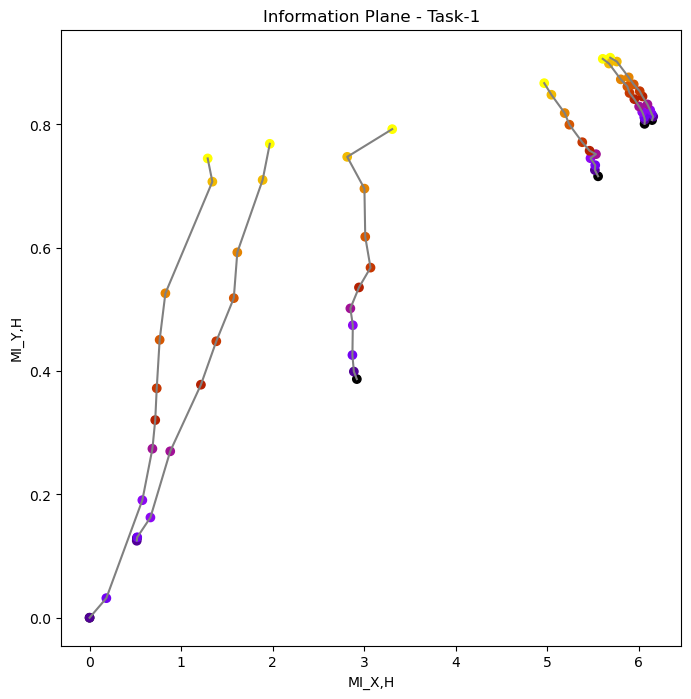

done!
        Train accuracy: 70.28974514563107
    Rehearsed on {(0, 2): {1: 2047, 0: 2049}}
    Testing Across Tasks
        Testing task: 1 / 1: 95%
        Testing global accuracy: 95%


In [9]:
# Pre-Training
taskNum = 0

print("Pre - Training")
print("    Online Mode")
print("        Training... ", end="")
model.train()
model.online()
parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
optimizer = optim.SGD(parameters,
                      lr=offline_lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
online_loader, test_loader = get_pretrain_loaders(tasks[taskNum])
accuracy = 0
N = 0
for batch_idx, (images, labels) in enumerate(online_loader, start=1):
  images, labels = images.to(device), labels.to(device)
  # forward pass
  h1, h2, h3, h4, h5 = model(images)
  h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

  loss = loss_function(h6, labels)

  # backpropagation
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # check if predicted labels are equal to true labels
  predicted_labels = torch.argmax(h6,dim=1)
  accuracy += torch.sum((predicted_labels==labels).float()).item()
  N += images.shape[0]
  model.update_storage(images, labels, tasks[taskNum])
print("done!")
print("        Train accuracy:", 100. * accuracy/N)

### Calculate Mutual Information  Online Phase ###

MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
MI_XH_tasks[taskNum, 0] = MI_XH
MI_YH_tasks[taskNum, 0] = MI_YH

print("    Offline Mode")
model.train()
model.offline()
parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
optimizer = optim.SGD(parameters,
                      lr=offline_lr,
                      momentum=momentum,
                      weight_decay=weight_decay)


print("        Epoch: ", end="")
for epoch in range(1, epochs+1):
  print(str(epoch) + ",", end="")
  #
  for localTaskNum, task in enumerate(tasks[:taskNum+1]):
    offline_loader = torch.utils.data.DataLoader(model.storage.get_data_by_task(task),
                                                  batch_size=batch_size, shuffle=True, drop_last=True)

    for batch_idx, (images, labels) in enumerate(offline_loader, start=1):
      images, labels = images.to(device), labels.to(device)

      # forward pass
      h1, h2, h3, h4, h5 = model(images)
      h6 = F.log_softmax(class_heads[localTaskNum](h5), dim = 1)
      loss = loss_function(h6, labels)

      # backpropagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # check if predicted labels are equal to true labels
      predicted_labels = torch.argmax(h6,dim=1)
      accuracy += torch.sum((predicted_labels==labels).float()).item()
      N += images.shape[0]
      model.update_storage(images, labels, tasks[taskNum])


  ### Calculate Mutual Information  Offline Phase ###

  MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
  MI_XH_tasks[taskNum, epoch] = MI_XH
  MI_YH_tasks[taskNum, epoch] = MI_YH

# plot results at the end of each task
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title(f'Information Plane - Task-{taskNum+1}')
cmap = plt.get_cmap('gnuplot', epochs+1)
colors = [cmap(i) for i in np.linspace(0, 1, epochs+1)]
ax.plot(MI_XH_tasks[taskNum], MI_YH_tasks[taskNum], '-', color='gray')
for layer in range(layers):
    im = ax.scatter(MI_XH_tasks[taskNum, :,layer], MI_YH_tasks[taskNum, :,layer], c=colors)

plt.show()

print("done!")
print("        Train accuracy:", 100. * accuracy/N)
print("    Rehearsed on", model.storage)
print("    Testing Across Tasks")
overall, specific = test_tasks(model, class_heads, tasks[:taskNum+1])
test_set_accuracy[taskNum] = specific

Pre - Training
    Online Mode
        Training... done!
        Train accuracy: 52.1484375
done!
        Train accuracy: 51.26953125
done!
        Train accuracy: 50.390625
done!
        Train accuracy: 50.146484375
done!
        Train accuracy: 50.0390625
done!
        Train accuracy: 50.162760416666664
done!
        Train accuracy: 49.916294642857146
done!
        Train accuracy: 49.8779296875
done!
        Train accuracy: 49.782986111111114
done!
        Train accuracy: 49.94140625
done!
        Train accuracy: 49.85795454545455
done!
        Train accuracy: 49.983723958333336
done!
        Train accuracy: 49.86478365384615
done!
        Train accuracy: 49.874441964285715
done!
        Train accuracy: 49.947916666666664
done!
        Train accuracy: 50.0244140625
done!
        Train accuracy: 49.95404411764706
done!
        Train accuracy: 49.89149305555556
done!
        Train accuracy: 49.9280427631579
done!
        Train accuracy: 49.8046875
done!
        Train accuracy: 49.81398

<Figure size 640x480 with 0 Axes>

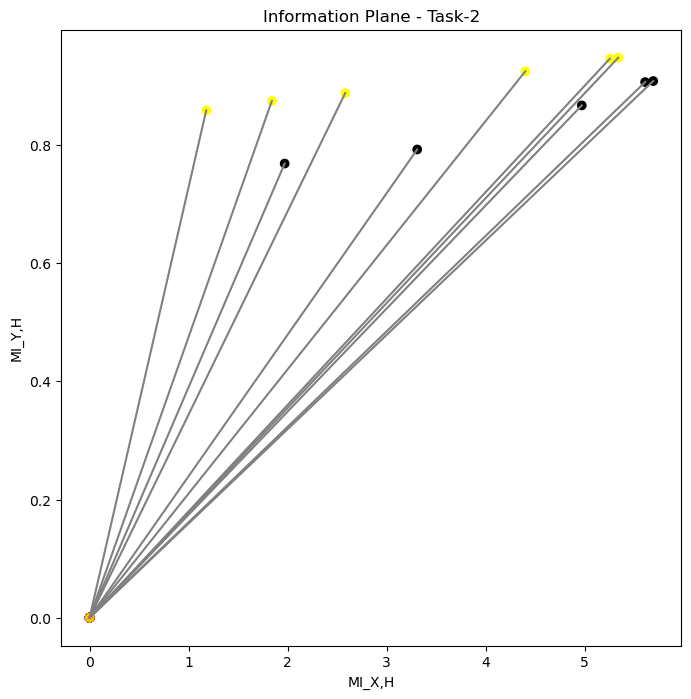

done!
        Train accuracy: 61.357717803030305
    Rehearsed on {(0, 2): {1: 1023, 0: 1024}, (5, 6): {1: 1024, 0: 1025}}
    Testing Across Tasks
        Testing task: 1 / 2: 98%
        Testing task: 2 / 2: 17%
        Testing global accuracy: 59%
done!
        Train accuracy: 62.40234375
done!
        Train accuracy: 63.38169642857143
done!
        Train accuracy: 64.33919270833333
done!
        Train accuracy: 65.23965371621621
done!
        Train accuracy: 66.10300164473684
done!
        Train accuracy: 66.92207532051282
done!
        Train accuracy: 67.7001953125
done!
        Train accuracy: 68.4546493902439
done!
        Train accuracy: 69.14527529761905
done!
        Train accuracy: 69.7765261627907
done!
        Train accuracy: 70.38796164772727
done!
        Train accuracy: 70.98090277777777
done!
        Train accuracy: 71.5735394021739
done!
        Train accuracy: 72.11602393617021
done!
        Train accuracy: 72.61555989583333
done!
        Train accuracy: 73.110650510

<Figure size 640x480 with 0 Axes>

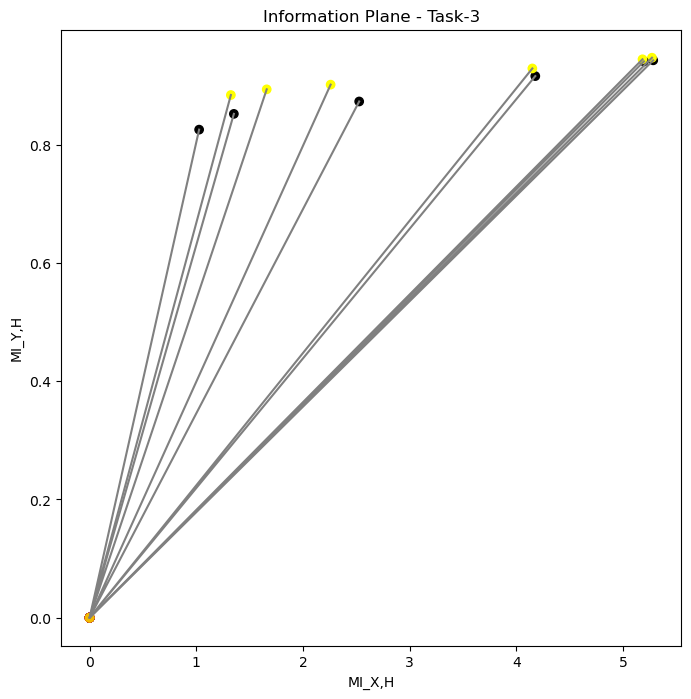

done!
        Train accuracy: 79.3057528409091
    Rehearsed on {(0, 2): {1: 682, 0: 682}, (5, 6): {1: 682, 0: 683}, (3, 8): {0: 683, 1: 684}}
    Testing Across Tasks
        Testing task: 1 / 3: 98%
        Testing task: 2 / 3: 18%
        Testing task: 3 / 3: 24%
        Testing global accuracy: 48%


In [10]:
# Pre-Training
taskNum = 0

print("Pre - Training")
print("    Online Mode")
print("        Training... ", end="")
model.train()
model.online()
parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
optimizer = optim.SGD(parameters,
                      lr=offline_lr,
                      momentum=momentum,
                      weight_decay=weight_decay)
online_loader, test_loader = get_pretrain_loaders(tasks[taskNum])
accuracy = 0
N = 0

for taskNum in range(1, len(tasks)):
    for batch_idx, (images, labels) in enumerate(online_loader, start=1):
        images, labels = images.to(device), labels.to(device)
        # forward pass
        h1, h2, h3, h4, h5 = model(images)
        h6 = F.log_softmax(class_heads[taskNum](h5), dim = 1)

        loss = loss_function(h6, labels)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
        model.update_storage(images, labels, tasks[taskNum])
        print("done!")
        print("        Train accuracy:", 100. * accuracy/N)

        ### Calculate Mutual Information  Online Phase ###

        MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
        MI_XH_tasks[taskNum, 0] = MI_XH
        MI_YH_tasks[taskNum, 0] = MI_YH

    print("    Offline Mode")
    model.train()
    model.offline()
    parameters = list(model.parameters()) + list(class_heads[taskNum].parameters())
    optimizer = optim.SGD(parameters,
                        lr=offline_lr,
                        momentum=momentum,
                        weight_decay=weight_decay)


    print("        Epoch: ", end="")
    for epoch in range(1, epochs+1):
        print(str(epoch) + ",", end="")
        #
        for localTaskNum, task in enumerate(tasks[:taskNum+1]):
            offline_loader = torch.utils.data.DataLoader(model.storage.get_data_by_task(task),
                                                        batch_size=batch_size, shuffle=True, drop_last=True)

            for batch_idx, (images, labels) in enumerate(offline_loader, start=1):
                images, labels = images.to(device), labels.to(device)

                # forward pass
                h1, h2, h3, h4, h5 = model(images)
                h6 = F.log_softmax(class_heads[localTaskNum](h5), dim = 1)
                loss = loss_function(h6, labels)

                # backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        # check if predicted labels are equal to true labels
        predicted_labels = torch.argmax(h6,dim=1)
        accuracy += torch.sum((predicted_labels==labels).float()).item()
        N += images.shape[0]
        model.update_storage(images, labels, tasks[taskNum])


    ### Calculate Mutual Information  Offline Phase ###

    MI_XH, MI_YH = compute_mutual_information(model, class_heads, taskNum, MI_loader)
    MI_XH_tasks[taskNum, epoch] = MI_XH
    MI_YH_tasks[taskNum, epoch] = MI_YH

    # plot results at the end of each task
    plt.figure()
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlabel('MI_X,H')
    ax.set_ylabel('MI_Y,H')
    title = ax.set_title(f'Information Plane - Task-{taskNum+1}')
    cmap = plt.get_cmap('gnuplot', epochs+1)
    colors = [cmap(i) for i in np.linspace(0, 1, epochs+1)]
    ax.plot(MI_XH_tasks[taskNum], MI_YH_tasks[taskNum], '-', color='gray')
    for layer in range(layers):
        im = ax.scatter(MI_XH_tasks[taskNum, :,layer], MI_YH_tasks[taskNum, :,layer], c=colors)

    plt.show()

    print("done!")
    print("        Train accuracy:", 100. * accuracy/N)
    print("    Rehearsed on", model.storage)
    print("    Testing Across Tasks")
    overall, specific = test_tasks(model, class_heads, tasks[:taskNum+1])
    test_set_accuracy[taskNum] = specific

In [11]:
#@title Compute Forgetting Metrics
ave_accuracy        = []
ave_inc_accuracy    = []
forgetting_measure  = []
backward_transfer   = []

# Compute average accuracy
for taskNum in range(len(tasks)):
    ave_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_accuracy[-1] += test_set_accuracy[taskNum][testTaskNum]
    ave_accuracy[-1] = ave_accuracy[-1] / (taskNum+1)

# Compute average incremental accuracy
for taskNum in range(len(tasks)):
    ave_inc_accuracy.append(0)
    for testTaskNum in range(taskNum+1):
      ave_inc_accuracy[-1] += ave_accuracy[testTaskNum]
    ave_inc_accuracy[-1] = ave_inc_accuracy[-1] / (taskNum+1)

# Compute forgetting measure
for taskNum in range(1,len(tasks)):
    forgetting_measure.append(0)
    for testTaskNum in range(taskNum):
      f = -math.inf
      for i in range(testTaskNum, taskNum):
        if test_set_accuracy[i][testTaskNum] > f:
          f = test_set_accuracy[i][testTaskNum]
      forgetting_measure[-1] += f - test_set_accuracy[taskNum][testTaskNum]
    forgetting_measure[-1] = forgetting_measure[-1] / taskNum

# Compute backward transfer
for taskNum in range(1, len(tasks)):
    backward_transfer.append(0)
    for testTaskNum in range(taskNum):
      backward_transfer[-1] += test_set_accuracy[taskNum][testTaskNum] - test_set_accuracy[testTaskNum][testTaskNum]
    backward_transfer[-1] = backward_transfer[-1] / taskNum

print("Average Accuracy:", ave_accuracy)
print("Average Incremental Accuracy:", ave_inc_accuracy)
print("Forgetting Measure:", forgetting_measure)
print("Backward Transfer:", backward_transfer)

Average Accuracy: [94.98011928429423, 57.12712911718876, 46.88145527445614]
Average Incremental Accuracy: [94.98011928429423, 76.0536242007415, 66.3295678919797]
Forgetting Measure: [-2.7335984095427506, -1.0226747622373846]
Backward Transfer: [2.7335984095427506, 2.38947396700876]


NameError: name 'XH_data' is not defined

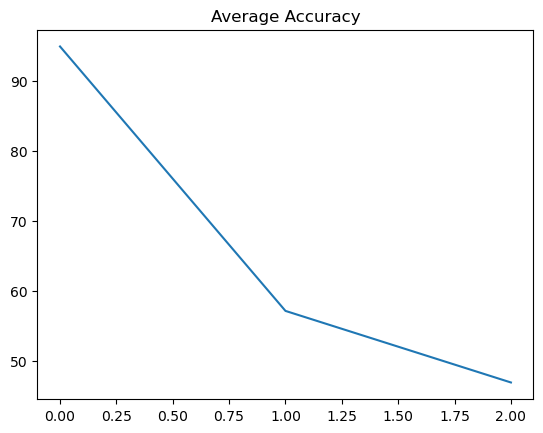

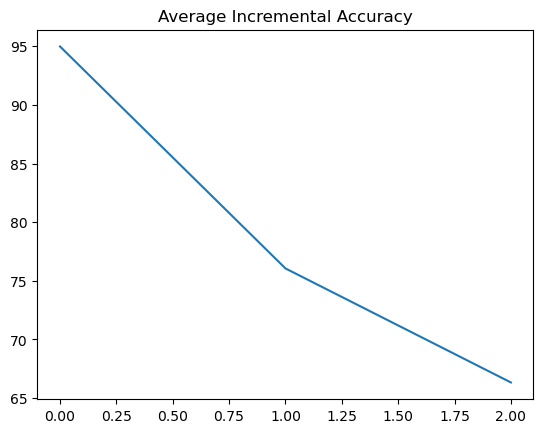

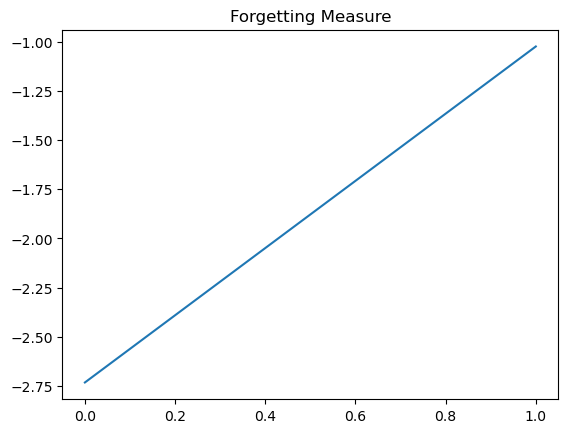

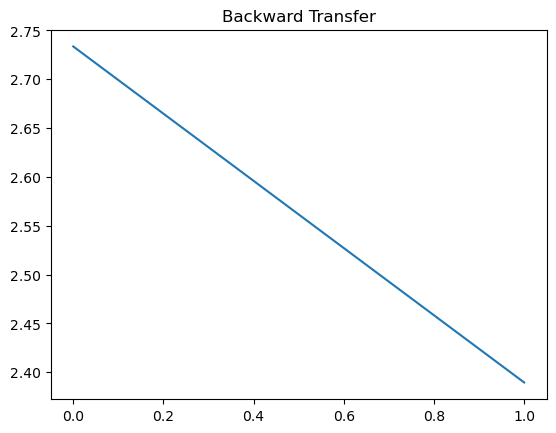

<Figure size 640x480 with 0 Axes>

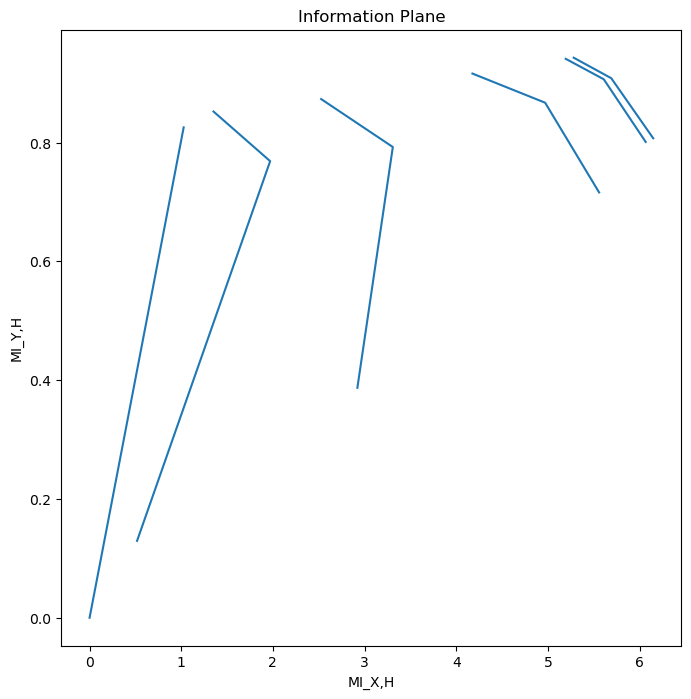

In [12]:
#@title Plot Results
# Plot average accuracy
plt.figure()
plt.title("Average Accuracy")
plt.plot(ave_accuracy)

# Plot average incremental accuracy
plt.figure()
plt.title("Average Incremental Accuracy")
plt.plot(ave_inc_accuracy)

# Plot forgetting measure
plt.figure()
plt.title("Forgetting Measure")
plt.plot(forgetting_measure)

# Plot backward transfer
plt.figure()
plt.title("Backward Transfer")
plt.plot(backward_transfer)

# Construct figure
plt.figure()
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_xlabel('MI_X,H')
ax.set_ylabel('MI_Y,H')
title = ax.set_title('Information Plane')

# Construct task colour map (for dots)
cmap_dots = plt.get_cmap('gnuplot', len(tasks))
dot_colors = [cmap_dots(i) for i in np.arange(0, len(tasks))]

# Construct layer colour map (for lines)
cmap_lines = plt.get_cmap('tab10', layers)
line_colors = [cmap_lines(i) for i in np.arange(0, layers)]
for layer in range(layers):
    ax.plot(MI_XH_tasks[:,layer], MI_YH_tasks[:,layer], '-', color=line_colors[layer], label="Layer " + str(layer+1))
    im = ax.scatter(XH_data, YH_data, c=dot_colors)
ax.legend()